In [1]:
# import 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import copy

In [2]:
# draw:
def plt_show(title,img,cmap = None):
    fig = plt.figure()
    plt.title(title)
    plt.imshow(img,cmap=cmap)
    plt.show()

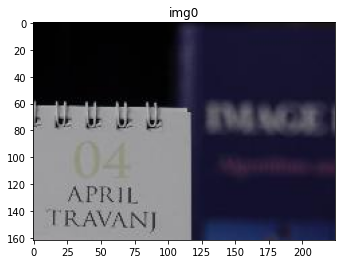

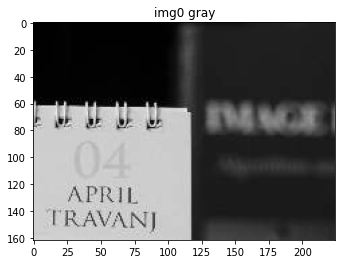

In [3]:
# load 
img0 = cv2.imread('p30a.jpg')
# show:
img0_gray = cv2.cvtColor(img0,cv2.COLOR_BGR2GRAY)
img0_color = cv2.cvtColor(img0,cv2.COLOR_BGR2RGB)
plt_show("img0",img0_color)
plt_show("img0 gray",img0_gray,cmap="gray")

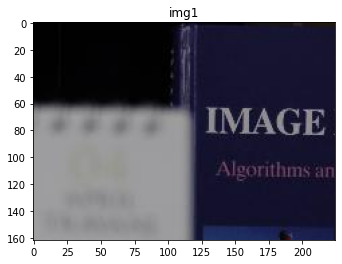

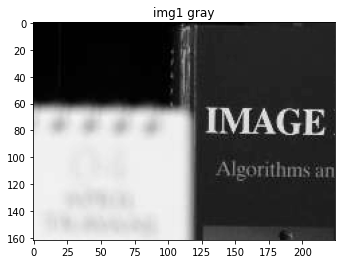

In [4]:
# load another img:
img1 = cv2.imread('p30b.jpg')
# show:
img1_gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img1_color = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
plt_show("img1",img1_color)
plt_show("img1 gray",img1_gray,cmap="gray")

In [5]:
# kernel and level define:
kernel = 1/16*np.array([1,4,6,4,1])
level = 3

In [6]:
# transfer int to uint:
def int2uint(number):
    if len(number.shape)>1:
        number[number<0] = 0
        number[number>255] = 255
        return number.astype('uint8')

In [7]:
# 对图像构建高斯金字塔：
def gauss_pyramid(img,level):
    gauss_pyr = []
    img_c = copy.deepcopy(img)
    # 放原图作为第零层：
    gauss_pyr.append(img_c)
    for i in range(level):
        img_c = cv2.pyrDown(img_c)
        plt_show("gauss pyr layer = {}".format(i+1),img_c,cmap="gray")
        gauss_pyr.append(img_c)
    return gauss_pyr

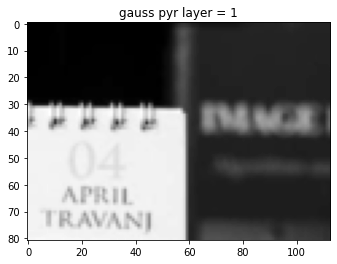

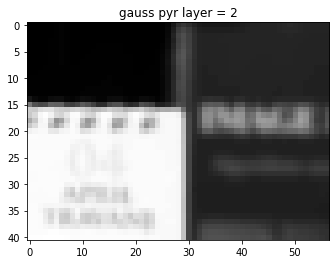

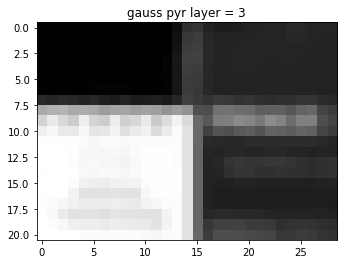

In [8]:
# img0 高斯金字塔：4 layer
img0_gauss_pyr = gauss_pyramid(img0_gray,level)

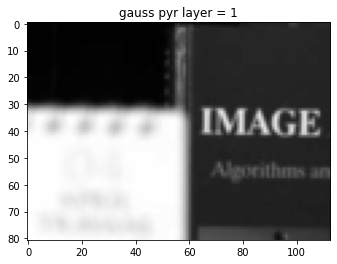

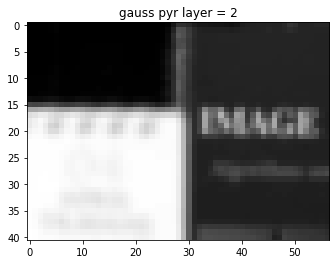

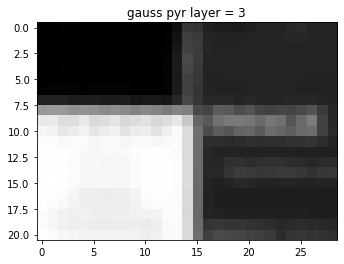

In [9]:
# img1 gaussian pyramid:
img1_gauss_pyr = gauss_pyramid(img1_gray,level)


In [10]:
# 拉普拉斯金字塔：
def lap_pyramid(gauss_pyr,level):
    lap_pyr = []
    for i in range(1,level+1):
        # expand:
        temp = cv2.pyrUp(gauss_pyr[i]) 
        # substract:
        width = min(gauss_pyr[i-1].shape[0],temp.shape[0])
        length = min(gauss_pyr[i-1].shape[1],temp.shape[1])
        a = np.array(gauss_pyr[i-1][:width,:length],dtype='int')
        b = np.array(temp[:width,:length],dtype='int')
        sub = a-b
        plt_show("lap lay={}".format(i-1),sub,cmap="gray")
        lap_pyr.append(sub)
    lap_pyr.append(gauss_pyr[level])
    return lap_pyr

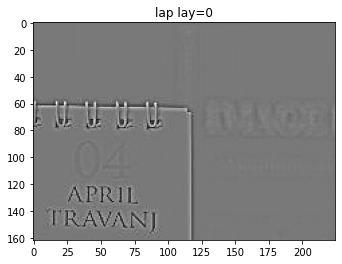

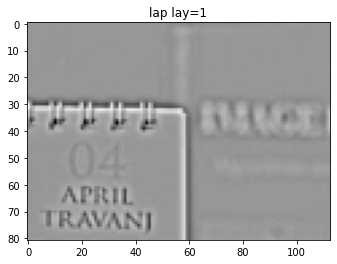

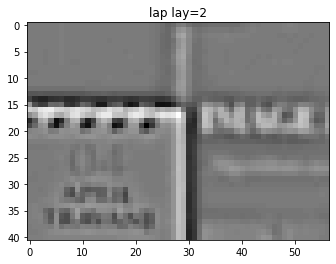

In [11]:
# img0 laplacian pyramid:
img0_lap_pyr =  lap_pyramid(img0_gauss_pyr,level)

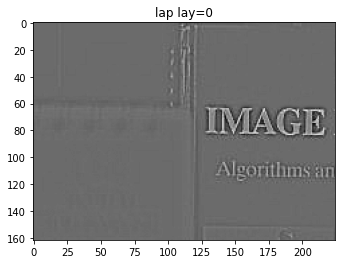

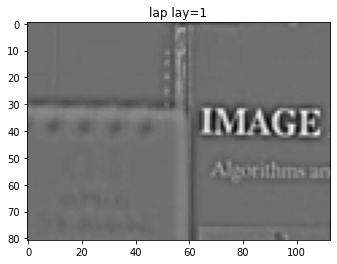

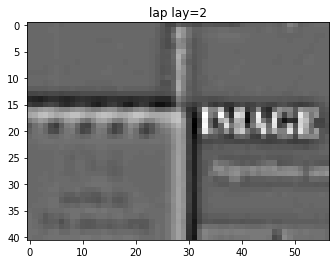

In [12]:
# im1 laplacian pyramid:
img1_lap_pyr =  lap_pyramid(img1_gauss_pyr,level)

In [13]:
# 对拉普拉斯金字塔的不同层定义mask（exclude最后一层low-pass bands）
def enhancement_mask(img0_lap_pyr,img1_lap_pyr):
    mask = []
    for i in range(level):
        # fix size:
        width = min(img0_lap_pyr[i].shape[0],img1_lap_pyr[i].shape[0])
        length = min(img0_lap_pyr[i].shape[1],img1_lap_pyr[i].shape[1])
        img0_lap_pyr[i] = img0_lap_pyr[i][:width,:length]
        img1_lap_pyr[i] = img1_lap_pyr[i][:width,:length]

        mask_layer = np.zeros((width,length))
        for w in range(width):
            for l in range(length):
                if abs(img0_lap_pyr[i][w,l])>abs(img1_lap_pyr[i][w,l]):
                    mask_layer[w,l] = 1

        # show:
        plt_show("mask layer = {}".format(i),mask_layer,cmap="gray")
        mask.append(mask_layer) 
    return mask

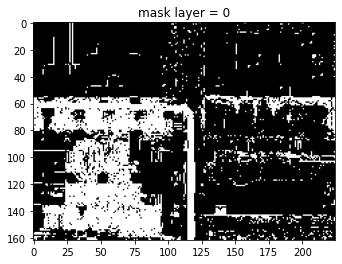

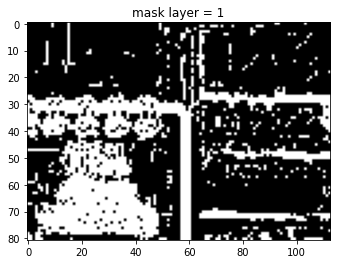

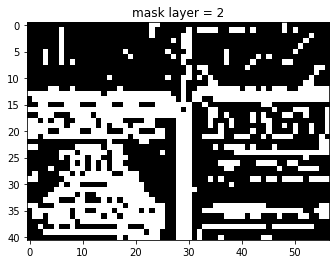

In [14]:
mask = enhancement_mask(img0_lap_pyr,img1_lap_pyr)

In [15]:
# 融合金字塔：
def blended_pyramid(img0_lap_pyr,img1_lap_pyr,mask):
    # 融合high-frequence:
    blend_pyr = []
    for i in range(level):
        a = img0_lap_pyr[i]
        b = img1_lap_pyr[i]
        c = mask[i]
        d = np.ones((c.shape))-c
        # add = int2uint(np.multiply(a,c)+np.multiply(b,d))
        add = np.multiply(a,c)+np.multiply(b,d)
        add[add>255]=255
        blend_pyr.append(add)
        # show:
        plt_show("blended b in layer{}".format(i),add,cmap="gray")

    # low pass average:
    avg = int2uint((np.array(img0_lap_pyr[level],dtype='int')+np.array(img1_lap_pyr[level],dtype='int'))/2)
    plt_show("blended b in low pass",avg,cmap="gray")
    blend_pyr.append(avg)

    return blend_pyr

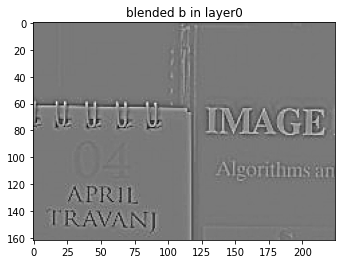

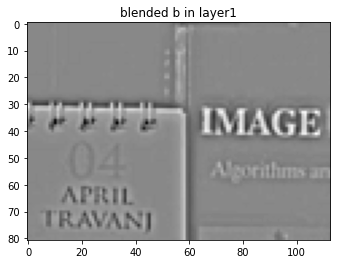

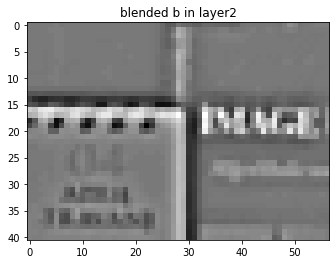

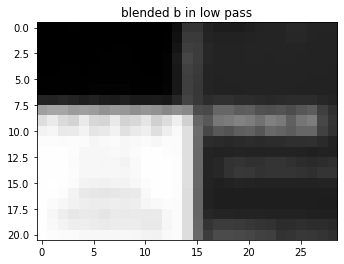

In [16]:
blended_pyr = blended_pyramid(img0_lap_pyr,img1_lap_pyr,mask)

In [17]:
# 重构：
def reconstruct(blended_pyr):
    reconstruct_pyr = []
    # add = np.array(blended_pyr[len(blended_pyr)-1],dtype='uint')
    add = np.array(blended_pyr[len(blended_pyr)-1])
    for i in range(len(blended_pyr)-1,0,-1):
        # extend
        temp = cv2.pyrUp(add)
        # add:
        width = min(temp.shape[0],blended_pyr[i-1].shape[0])
        length = min(temp.shape[1],blended_pyr[i-1].shape[1])
        print(temp.shape[0],blended_pyr[i-1].shape[0])
        a = np.array(temp[:width,:length],dtype='int')
        b = np.array(blended_pyr[i-1][:width,:length],dtype='int')
        add = int2uint(a+b)
        reconstruct_pyr.append(add)
        # show
        plt_show("layer={}".format(i),add,cmap="gray")

    return reconstruct_pyr

42 41


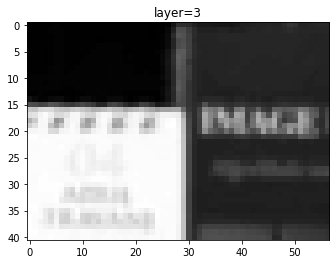

82 81


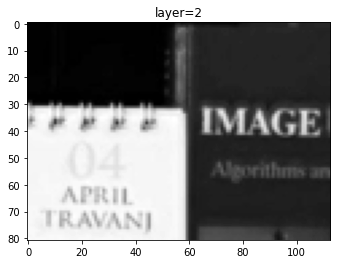

162 162


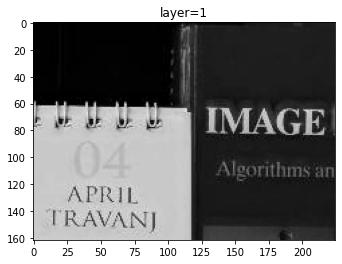

In [18]:
re_pyr = reconstruct(blended_pyr)

In [19]:
# 全流程：
def process(img0_gray,img1_gray):
    # 构建高斯金字塔：
    img0_gauss_pyr = gauss_pyramid(img0_gray,level)
    img1_gauss_pyr = gauss_pyramid(img1_gray,level)
    # 构建拉普拉斯金字塔：
    img0_lap_pyr =  lap_pyramid(img0_gauss_pyr,level)
    img1_lap_pyr =  lap_pyramid(img1_gauss_pyr,level)
    # 构建mask
    mask = enhancement_mask(img0_lap_pyr,img1_lap_pyr)
    # 构建融合金字塔：
    blended_pyr = blended_pyramid(img0_lap_pyr,img1_lap_pyr,mask)
    # 重构：
    re_pyr = reconstruct(blended_pyr)
    return re_pyr

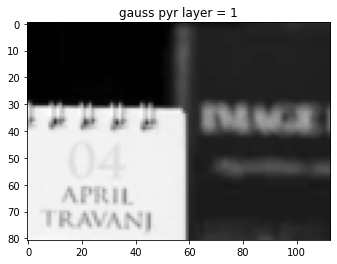

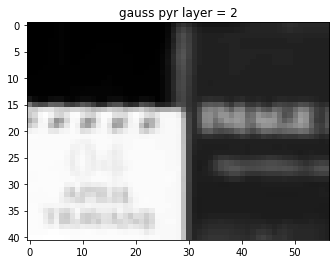

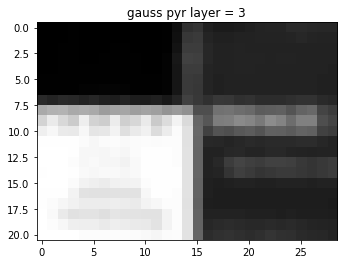

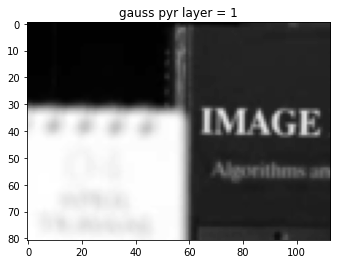

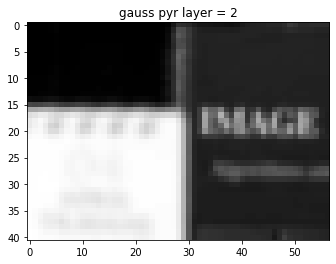

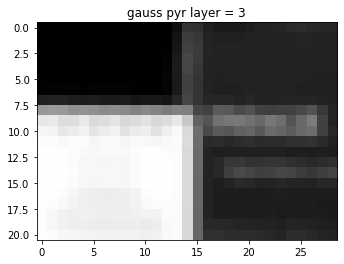

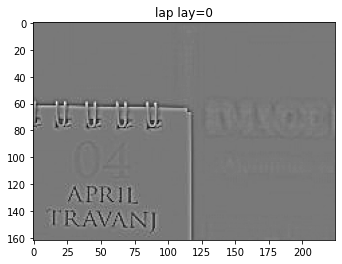

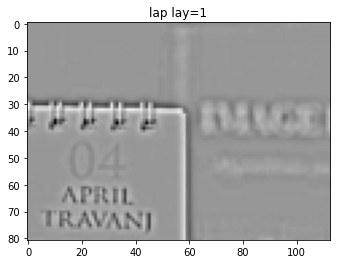

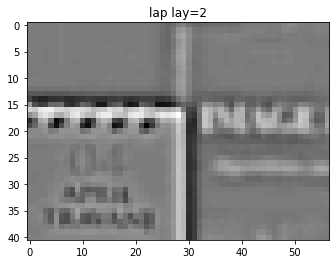

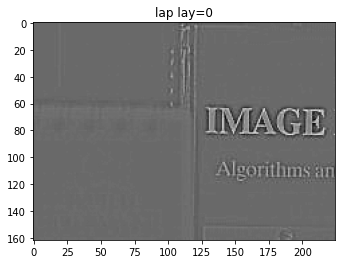

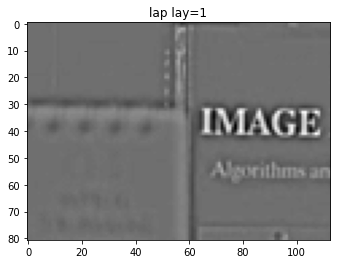

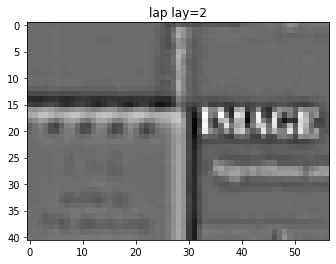

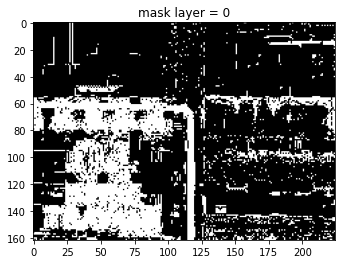

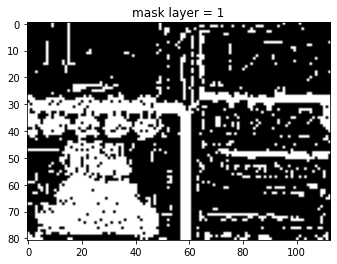

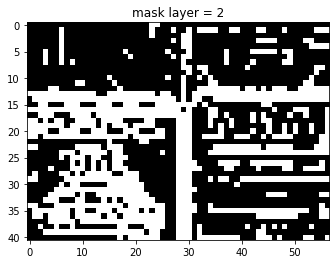

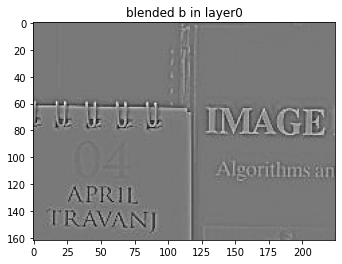

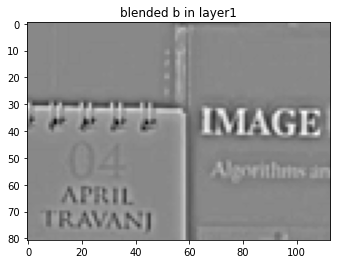

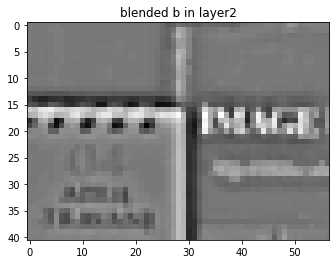

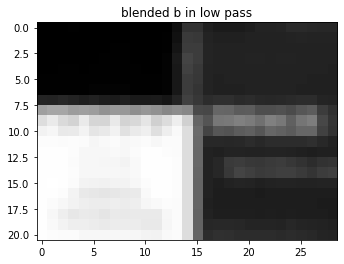

42 41


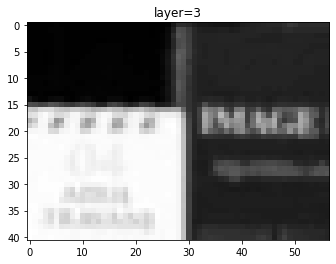

82 81


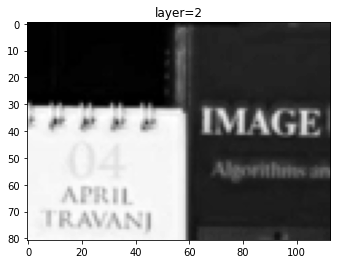

162 162


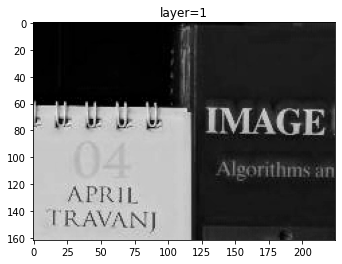

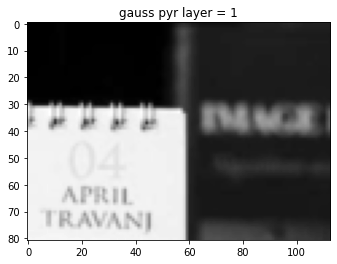

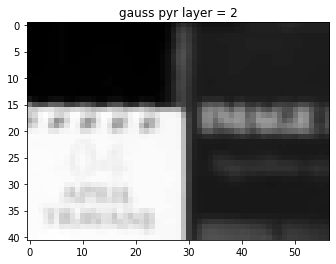

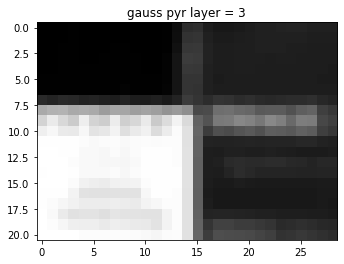

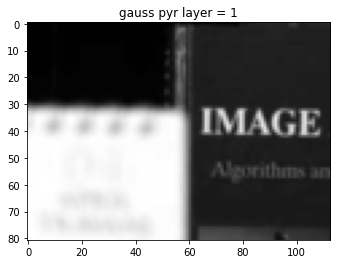

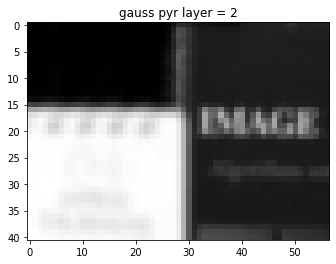

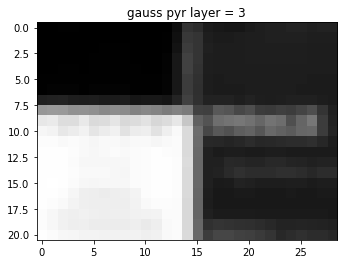

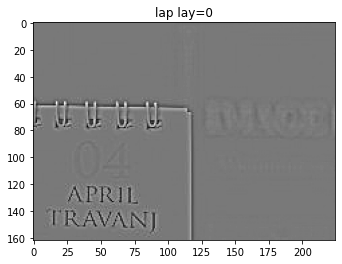

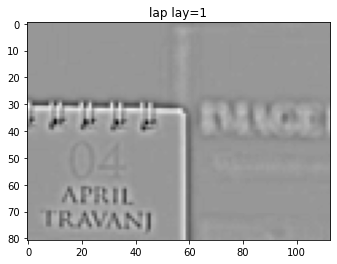

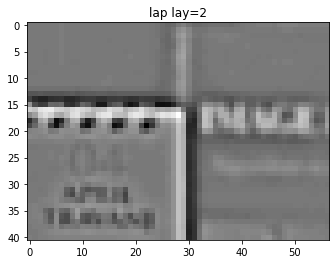

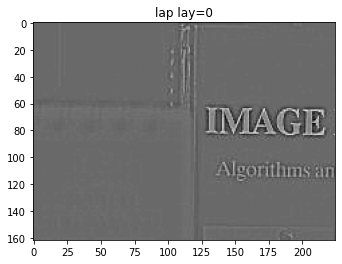

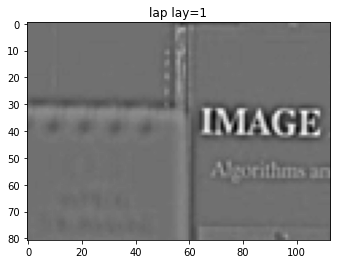

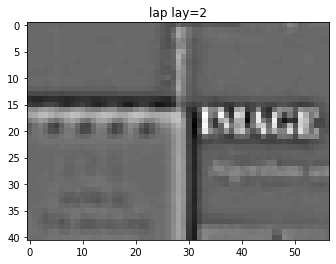

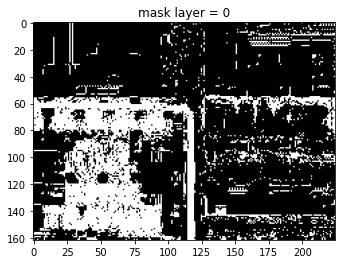

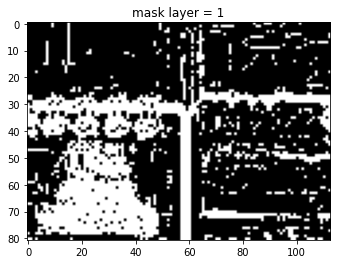

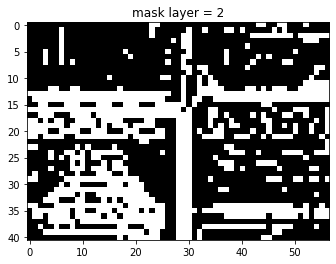

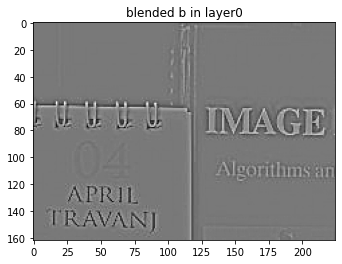

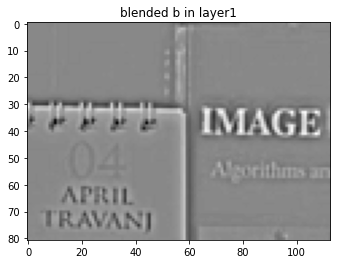

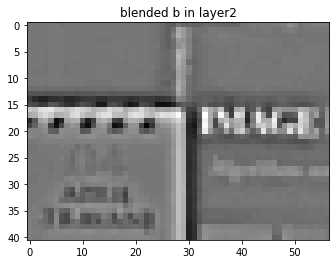

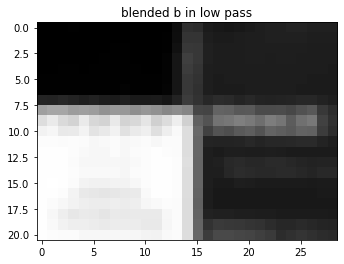

42 41


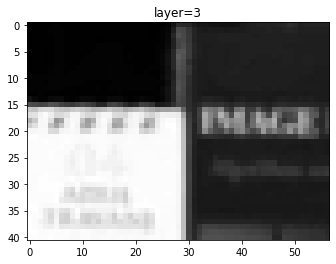

82 81


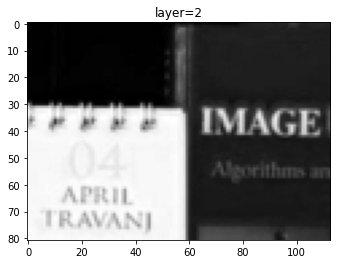

162 162


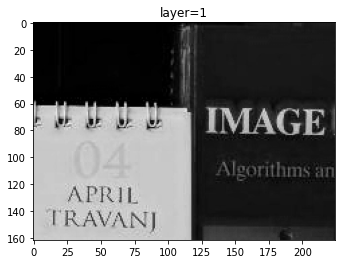

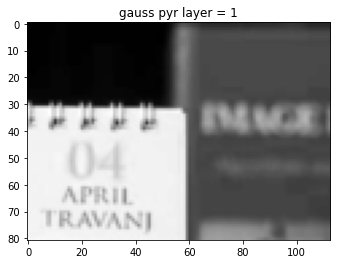

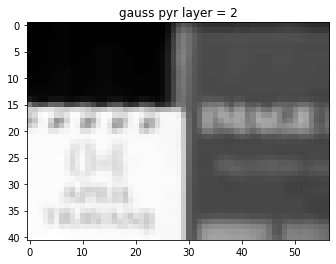

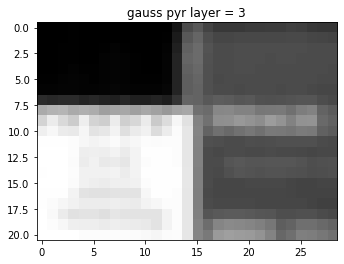

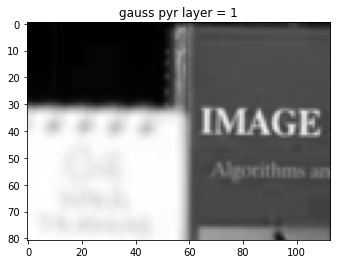

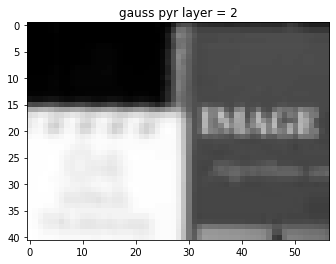

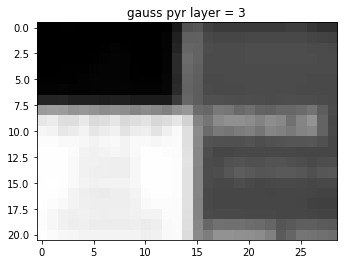

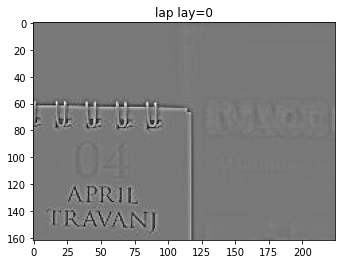

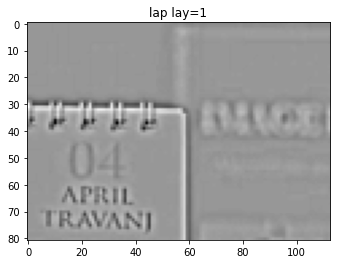

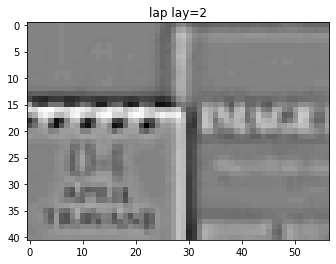

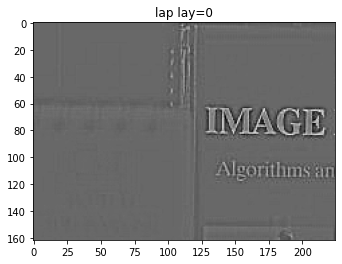

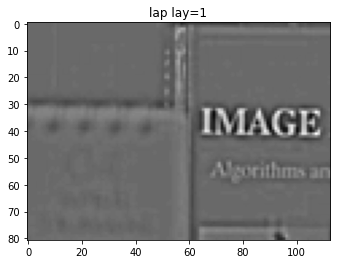

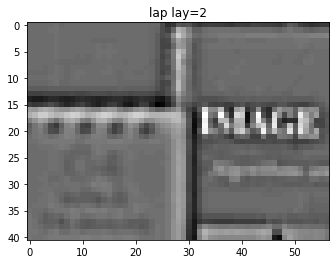

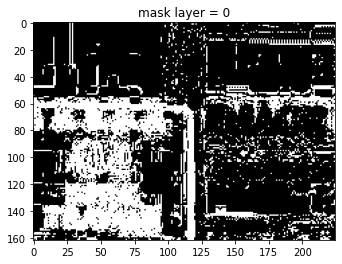

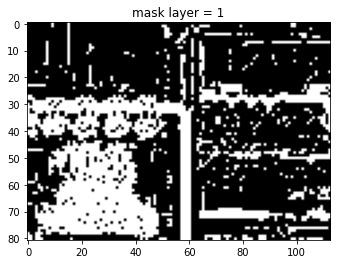

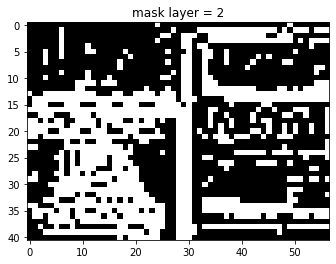

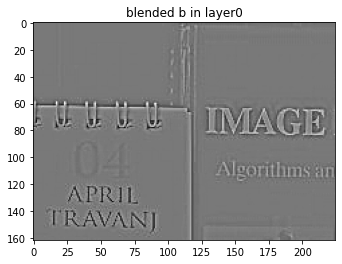

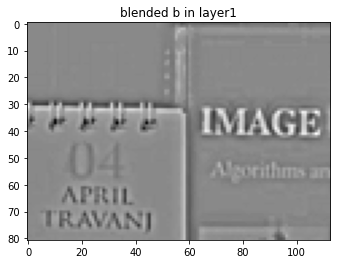

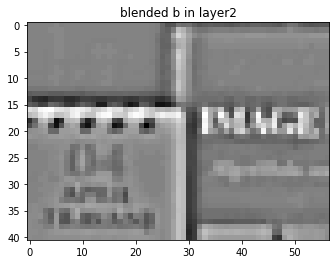

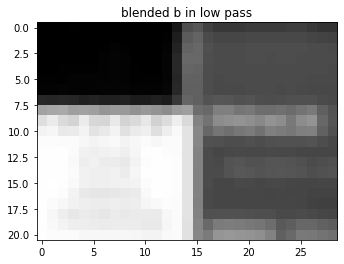

42 41


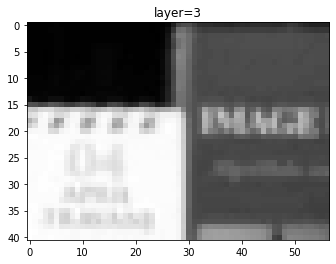

82 81


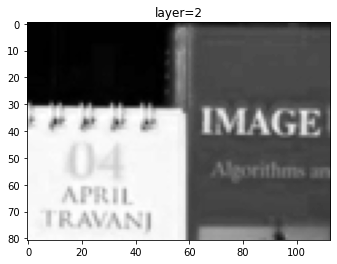

162 162


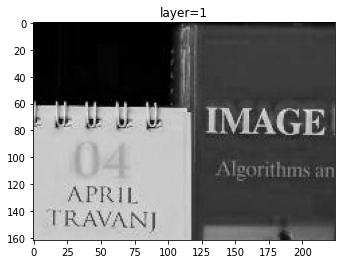

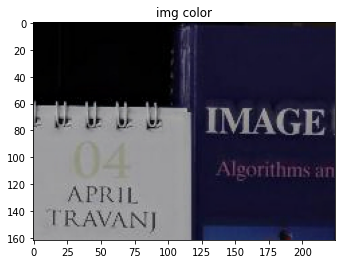

In [20]:
# 彩色图像处理：
re_pyr_r = process(img0_color[:,:,0],img1_color[:,:,0])
re_pyr_g = process(img0_color[:,:,1],img1_color[:,:,1])
re_pyr_b = process(img0_color[:,:,2],img1_color[:,:,2])
plt_show("img color",cv2.merge([re_pyr_r[-1],re_pyr_g[-1],re_pyr_b[-1]]))

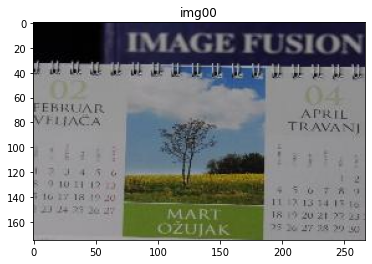

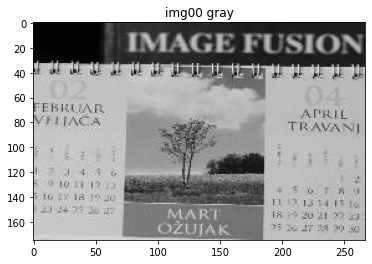

In [21]:
# 尝试另一幅图像：
# load img:
img00 = cv2.imread('t58a.jpg')
# show:
img00_gray = cv2.cvtColor(img00,cv2.COLOR_BGR2GRAY)
img00_color = cv2.cvtColor(img00,cv2.COLOR_BGR2RGB)
plt_show("img00",img00_color)
plt_show("img00 gray",img00_gray,cmap="gray")

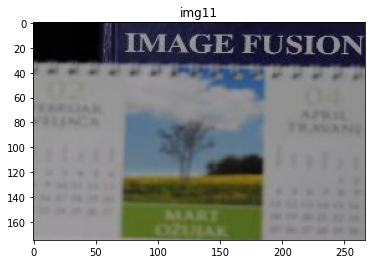

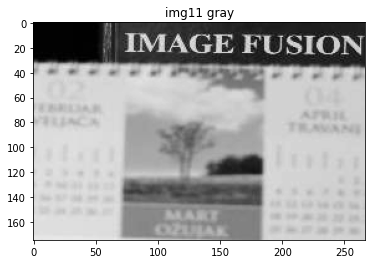

In [22]:
# load another img:
img11 = cv2.imread('t58b.jpg')
# show:
img11_gray = cv2.cvtColor(img11,cv2.COLOR_BGR2GRAY)
img11_color = cv2.cvtColor(img11,cv2.COLOR_BGR2RGB)
plt_show("img11",img11_color)
plt_show("img11 gray",img11_gray,cmap="gray")

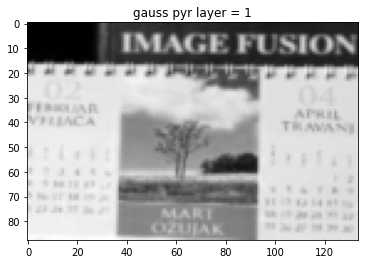

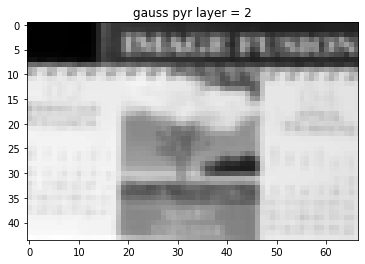

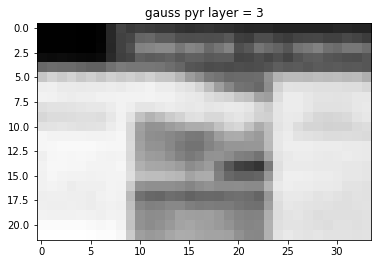

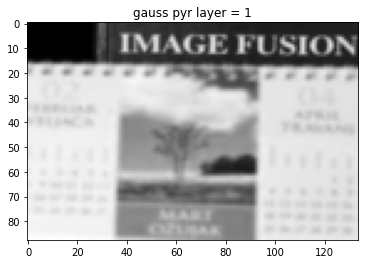

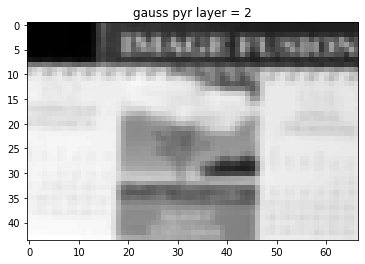

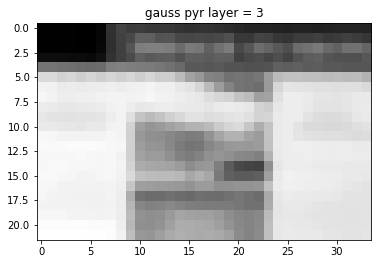

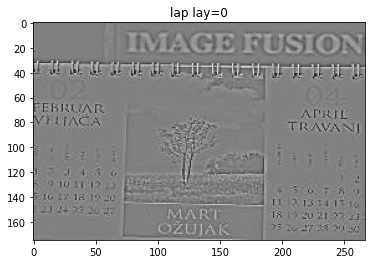

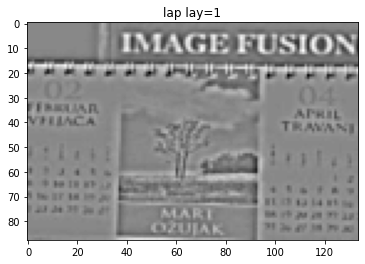

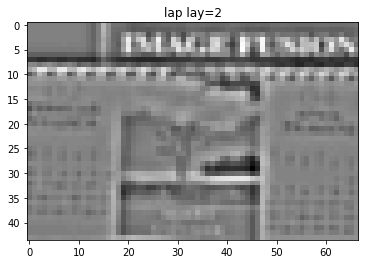

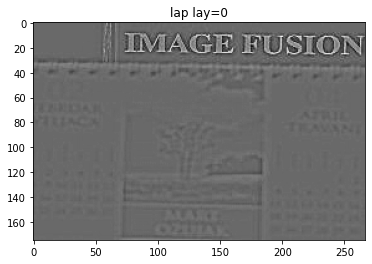

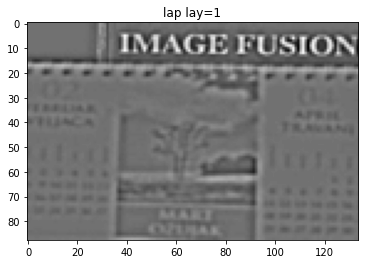

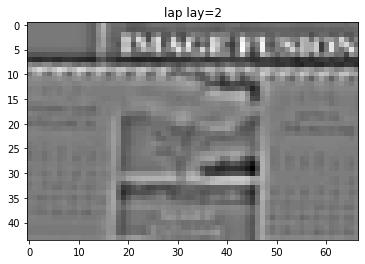

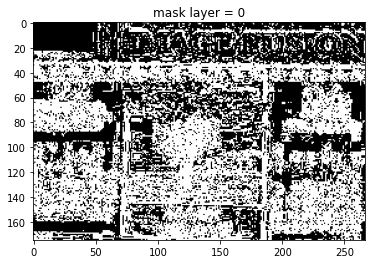

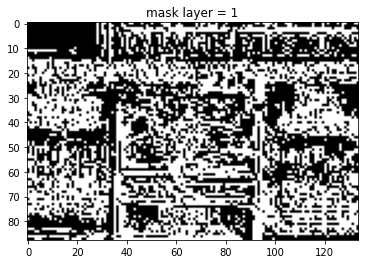

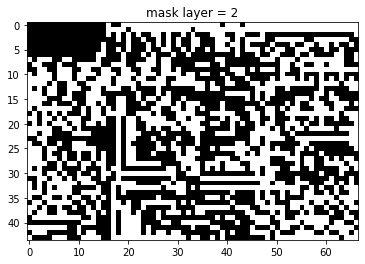

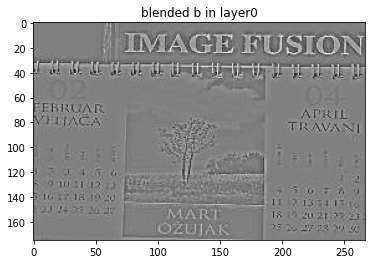

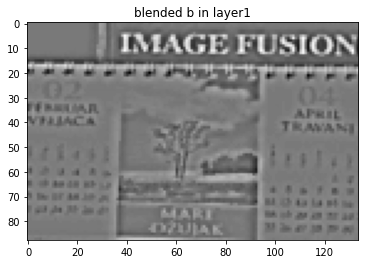

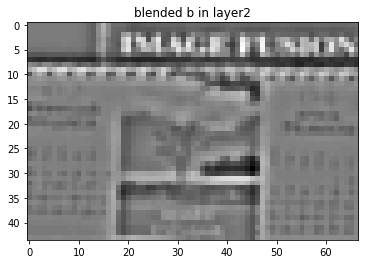

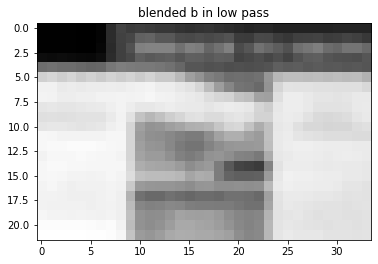

44 44


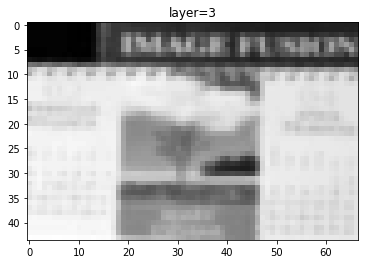

88 88


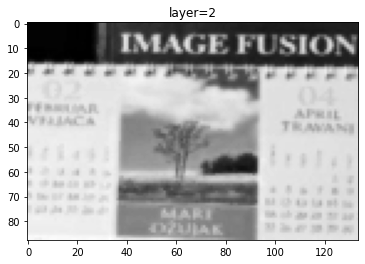

176 175


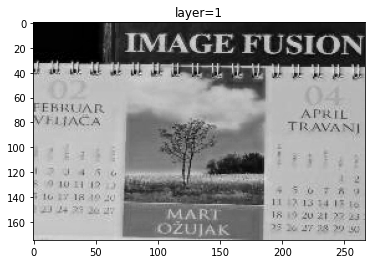

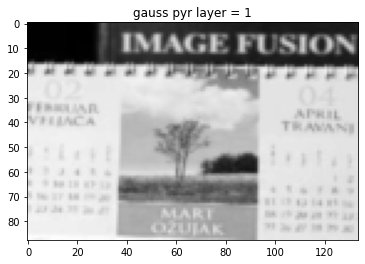

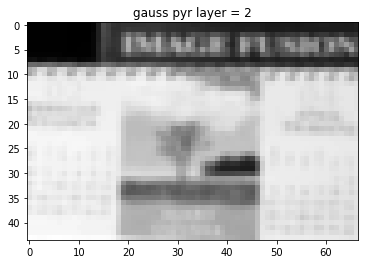

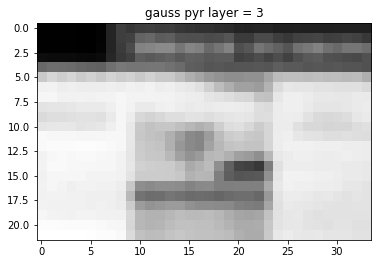

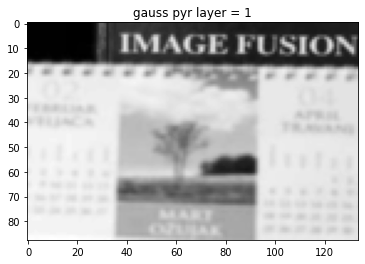

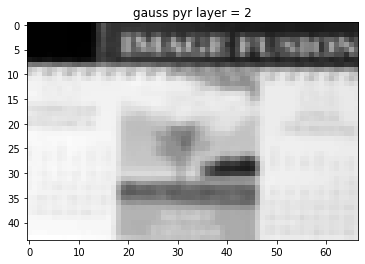

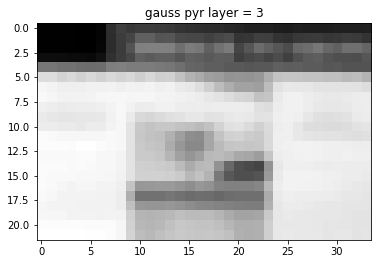

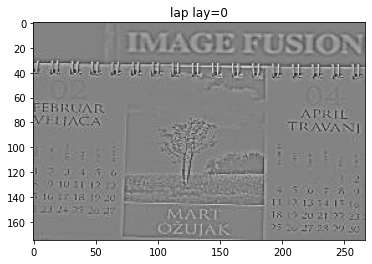

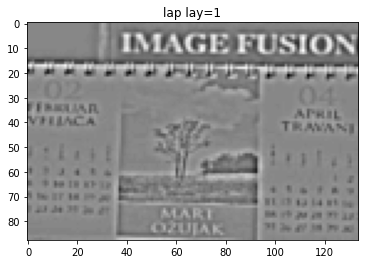

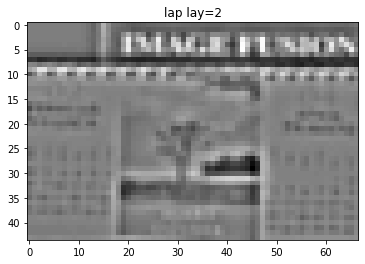

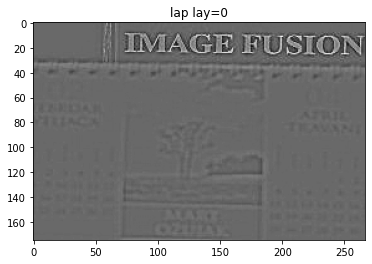

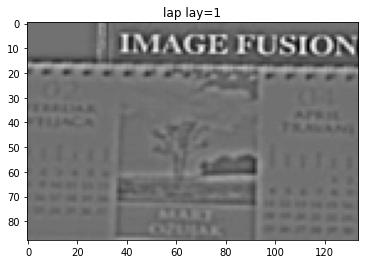

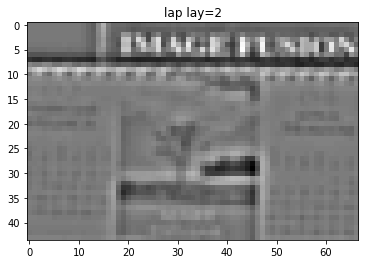

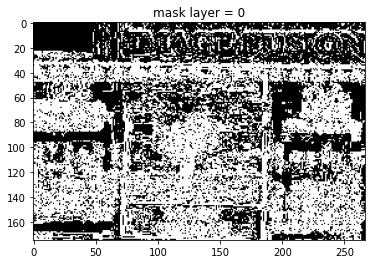

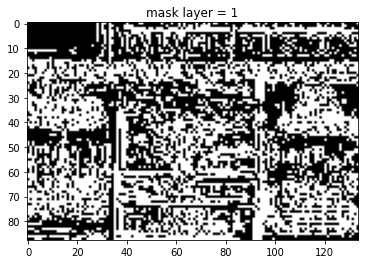

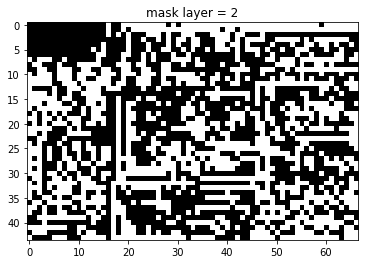

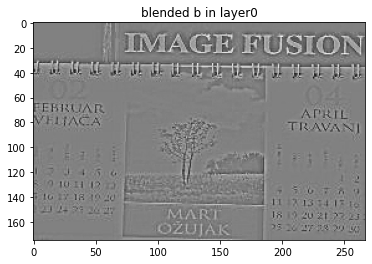

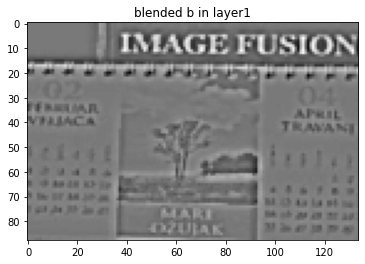

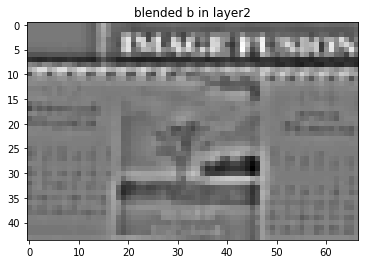

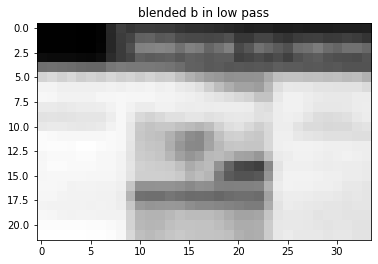

44 44


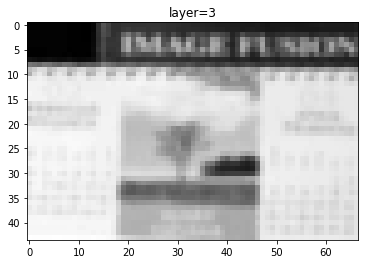

88 88


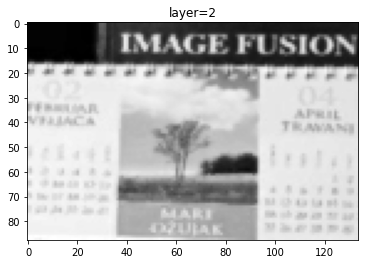

176 175


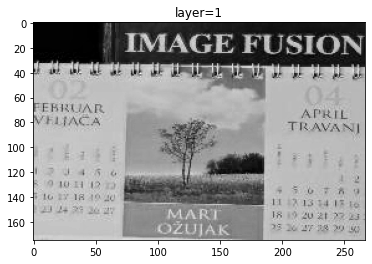

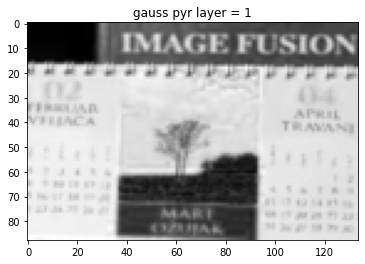

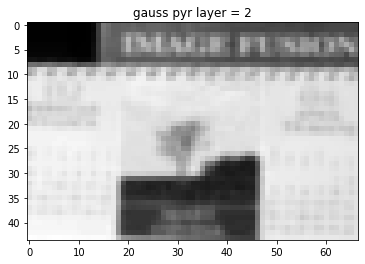

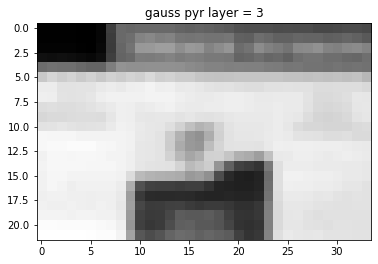

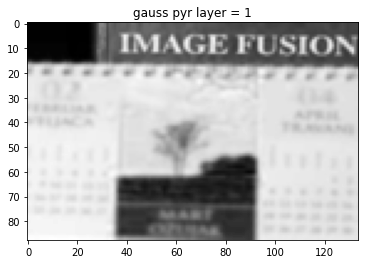

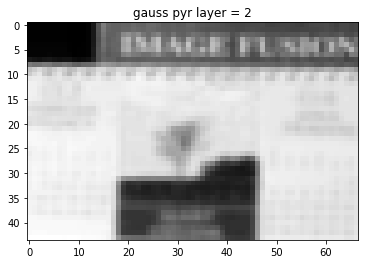

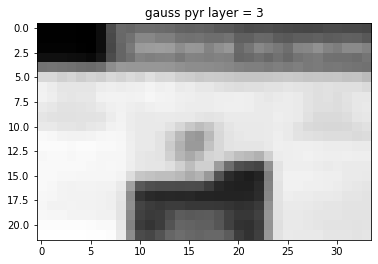

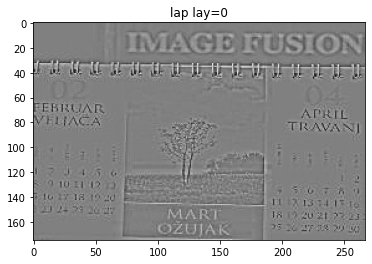

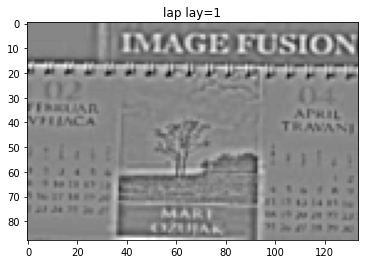

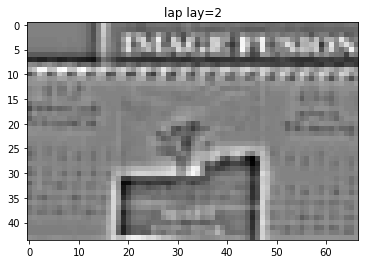

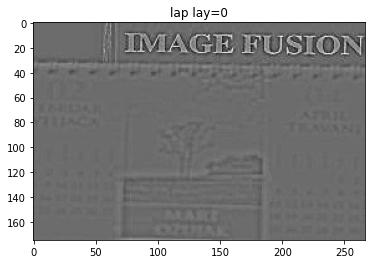

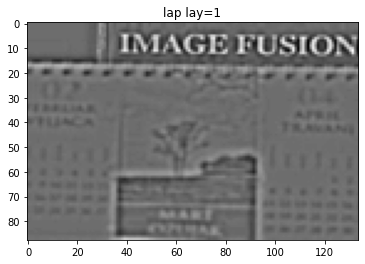

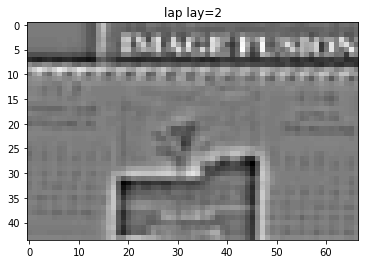

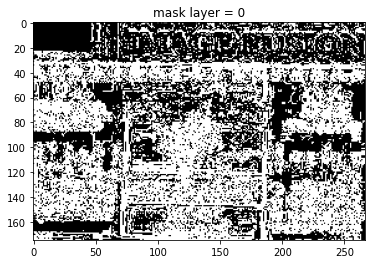

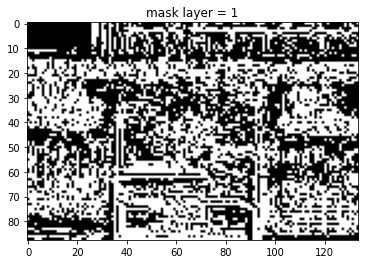

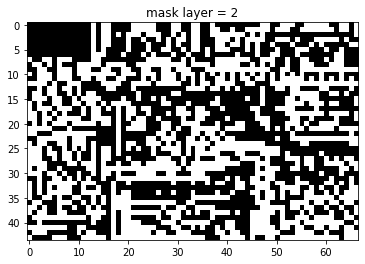

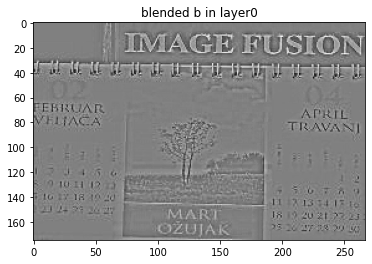

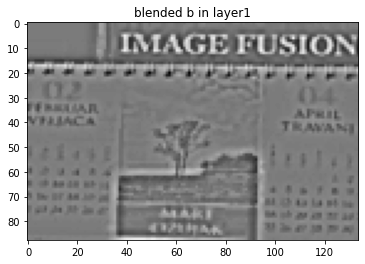

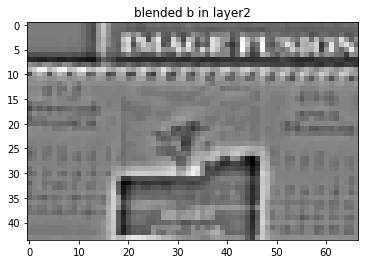

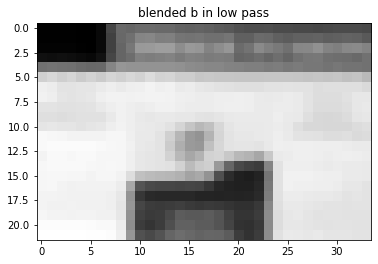

44 44


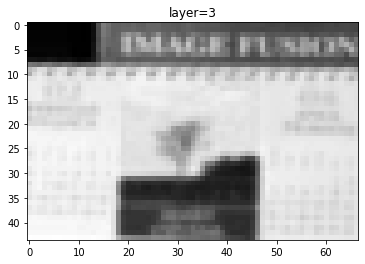

88 88


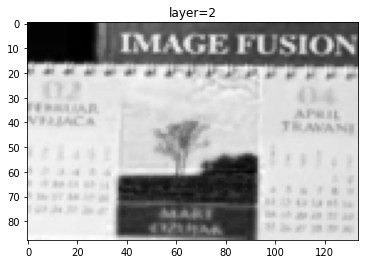

176 175


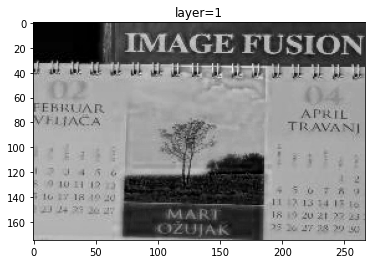

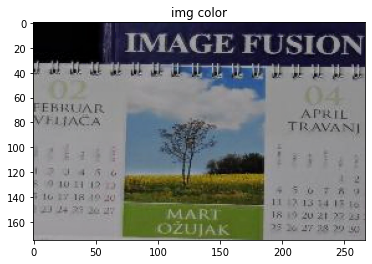

In [23]:
re_pyr_r = process(img00_color[:,:,0],img11_color[:,:,0])
re_pyr_g = process(img00_color[:,:,1],img11_color[:,:,1])
re_pyr_b = process(img00_color[:,:,2],img11_color[:,:,2])
plt_show("img color",cv2.merge([re_pyr_r[-1],re_pyr_g[-1],re_pyr_b[-1]]))